# 06 - Spotify Audio Features Exploratory Data Analysis

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq


warnings.filterwarnings('ignore')

sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Load data

In [2]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

,rank,song,artist_base,artist_all,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
1101,4,raindrops keep fallin' on my head,b.j. thomas,b.j. thomas,1970,NaN,raindrops keep fallin on my head,bj thomas,raindrops keep fallin on my head and just like...,NaN,...,NaN,NaN,NaN,NaN,NaN,179.0,NaN,81.0,1970,2.209877
3761,5,can't nobody hold me down,sean combs,puff daddy featuring mase,1997,mase,cant nobody hold me down,sean combs,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,NaN
3133,42,back to life (however do you want me),soul ii soul,soul ii soul featuring caron wheeler,1990,caron wheeler,back to life however do you want me,soul ii soul,back to life back to reality back to life back...,0.0673,...,0.129,101.001,4.0,0.653,3.868883,395.0,1.701611,81.0,1990,4.876543


## Univariate distributions

In [3]:
df.columns

Index(['rank', 'song', 'artist_base', 'artist_all', 'year', 'artist_featured',
       'song_clean', 'artist_clean', 'lyrics', 'acousticness', 'danceability',
       'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'popularity', 'release_date', 'speechiness', 'tempo',
       'time_signature', 'valence', 'duration_min', 'num_words',
       'words_per_sec', 'num_uniq_words', 'decade', 'uniq_ratio'],
      dtype='object')

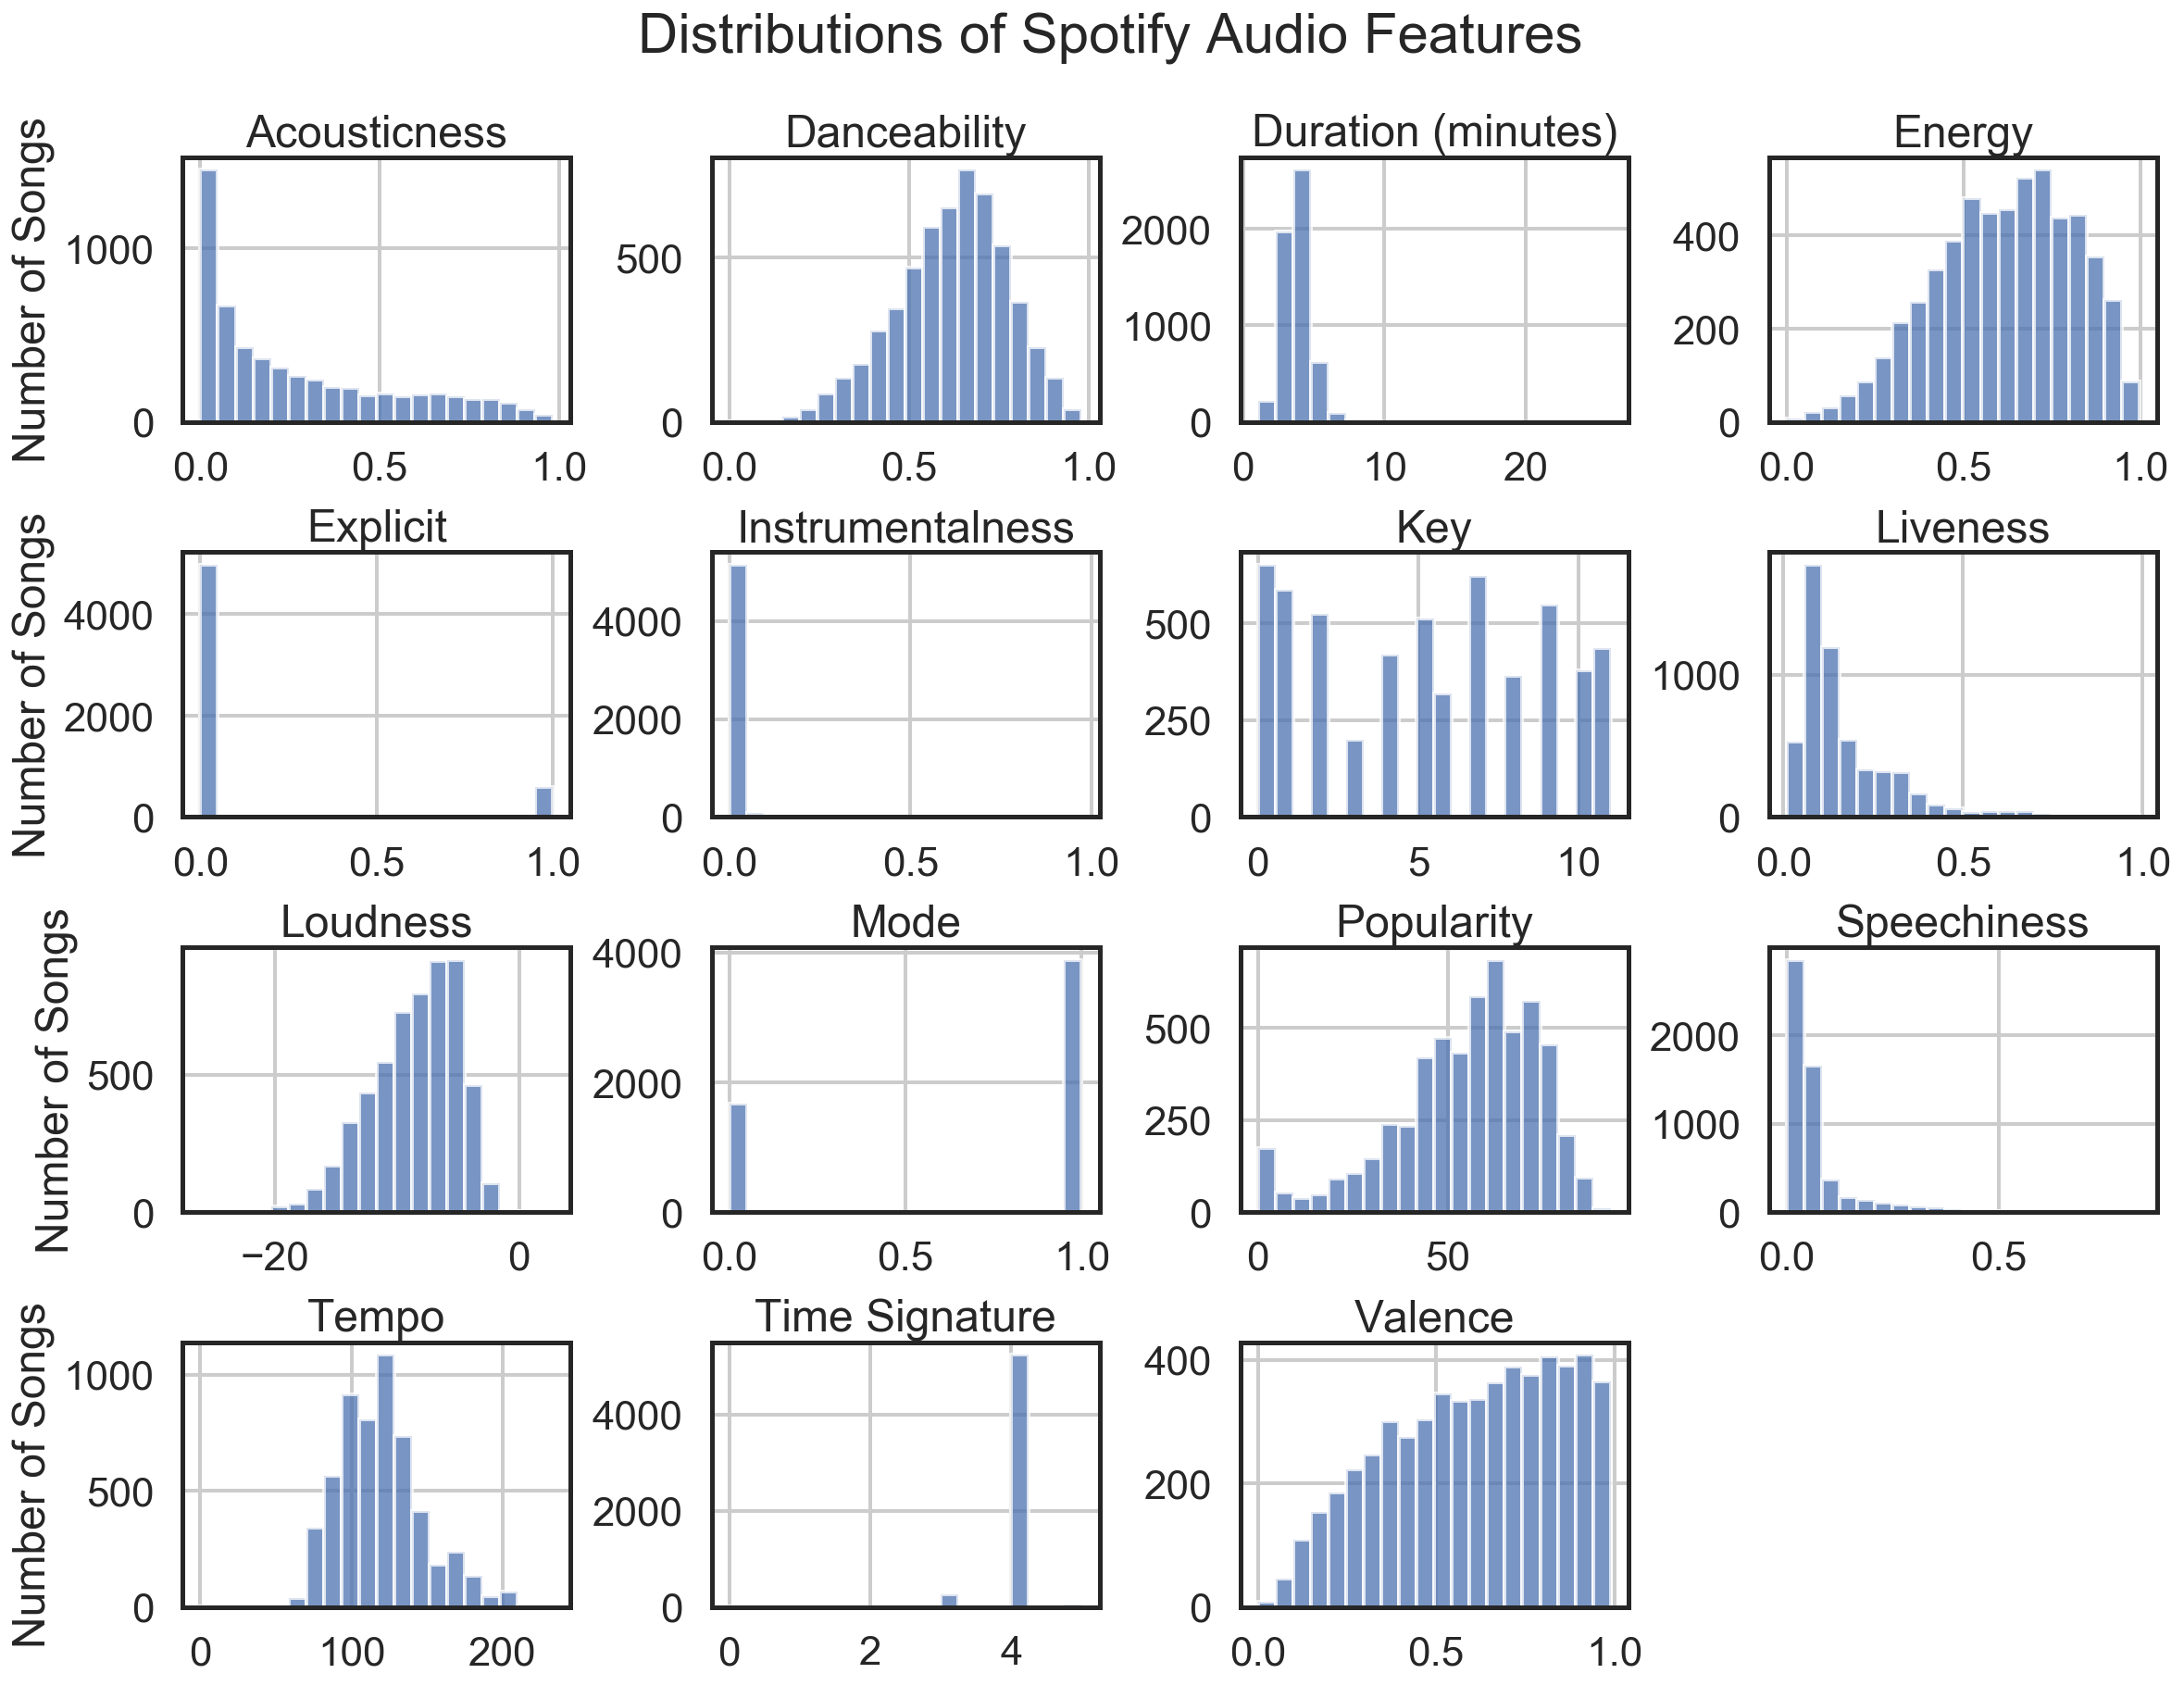

In [4]:
axes = df.drop(['year', 'rank', 'num_words', 'uniq_ratio', 'decade',
                'num_uniq_words', 'words_per_sec'], axis=1)\
         .hist(figsize=(16,12), bins=20, alpha=0.75);
axes = axes.ravel()
plt.tight_layout()

titles = ['Acousticness', 'Danceability', 'Duration (minutes)', 'Energy',
          'Explicit', 'Instrumentalness', 'Key', 'Liveness', 'Loudness', 'Mode',
          'Popularity', 'Speechiness', 'Tempo', 'Time Signature', 'Valence']
for i in range(len(axes)-1):
    axes[i].set_title(titles[i])
    if i % 4 == 0:
        axes[i].set_ylabel('Number of Songs')
plt.suptitle('Distributions of Spotify Audio Features', fontsize=30, y=1.05);
plt.savefig('univariate-distributions.png')

In [5]:
df[df['duration_min'] > 20]

,rank,song,artist_base,artist_all,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
1576,79,tubular bells,mike oldfield,mike oldfield,1974,NaN,tubular bells,mike oldfield,spoken grand piano reed and pipe organ glocken...,0.564,...,0.0343,103.535,4.0,0.0579,26.018883,27.0,0.017295,23.0,1970,1.173913


## Correlation heatmap 

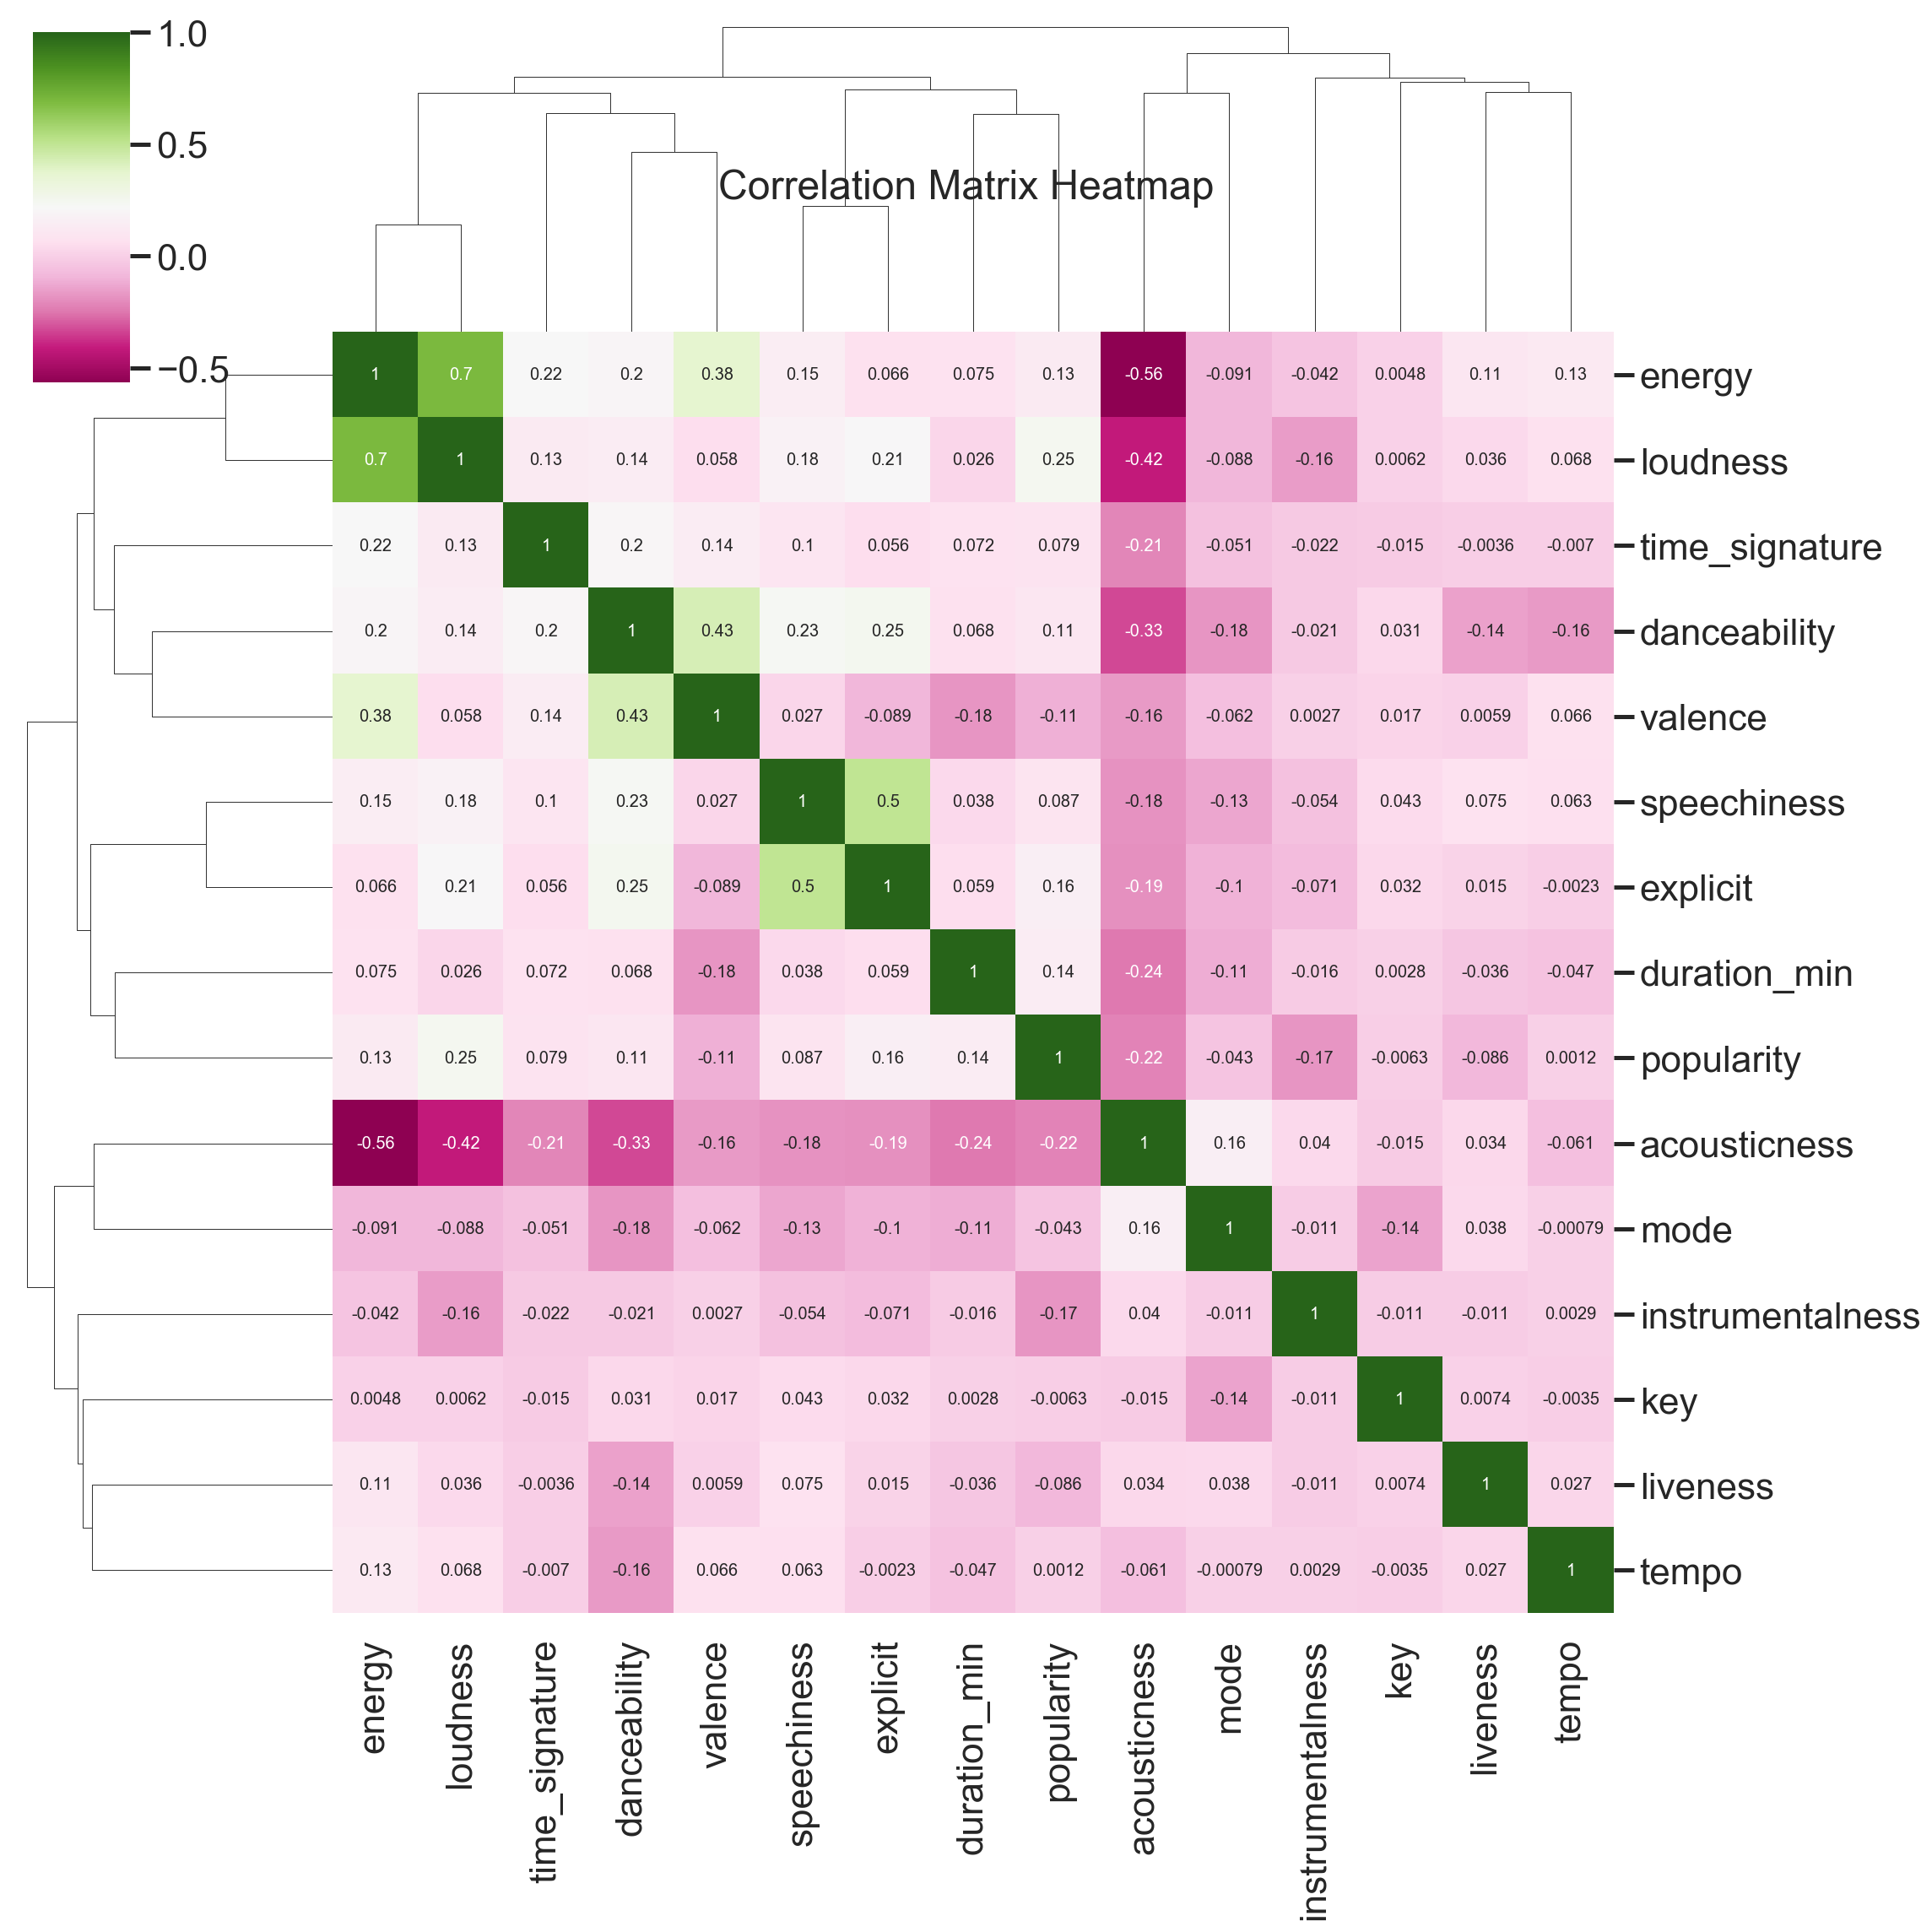

In [6]:
columns = ['acousticness', 'danceability', 'duration_min', 'energy',
           'instrumentalness', 'liveness', 'loudness', 'popularity',
           'speechiness', 'tempo', 'valence', 'time_signature', 'mode',
           'key', 'explicit']
df_scatter = df[columns]
sns.clustermap(df_scatter.corr(), cmap='PiYG', annot=True, figsize=(16,16))
plt.suptitle('Correlation Matrix Heatmap', fontsize=24, y=0.91)
plt.savefig('correlation-heatmap.png')

## Bivariate distributions

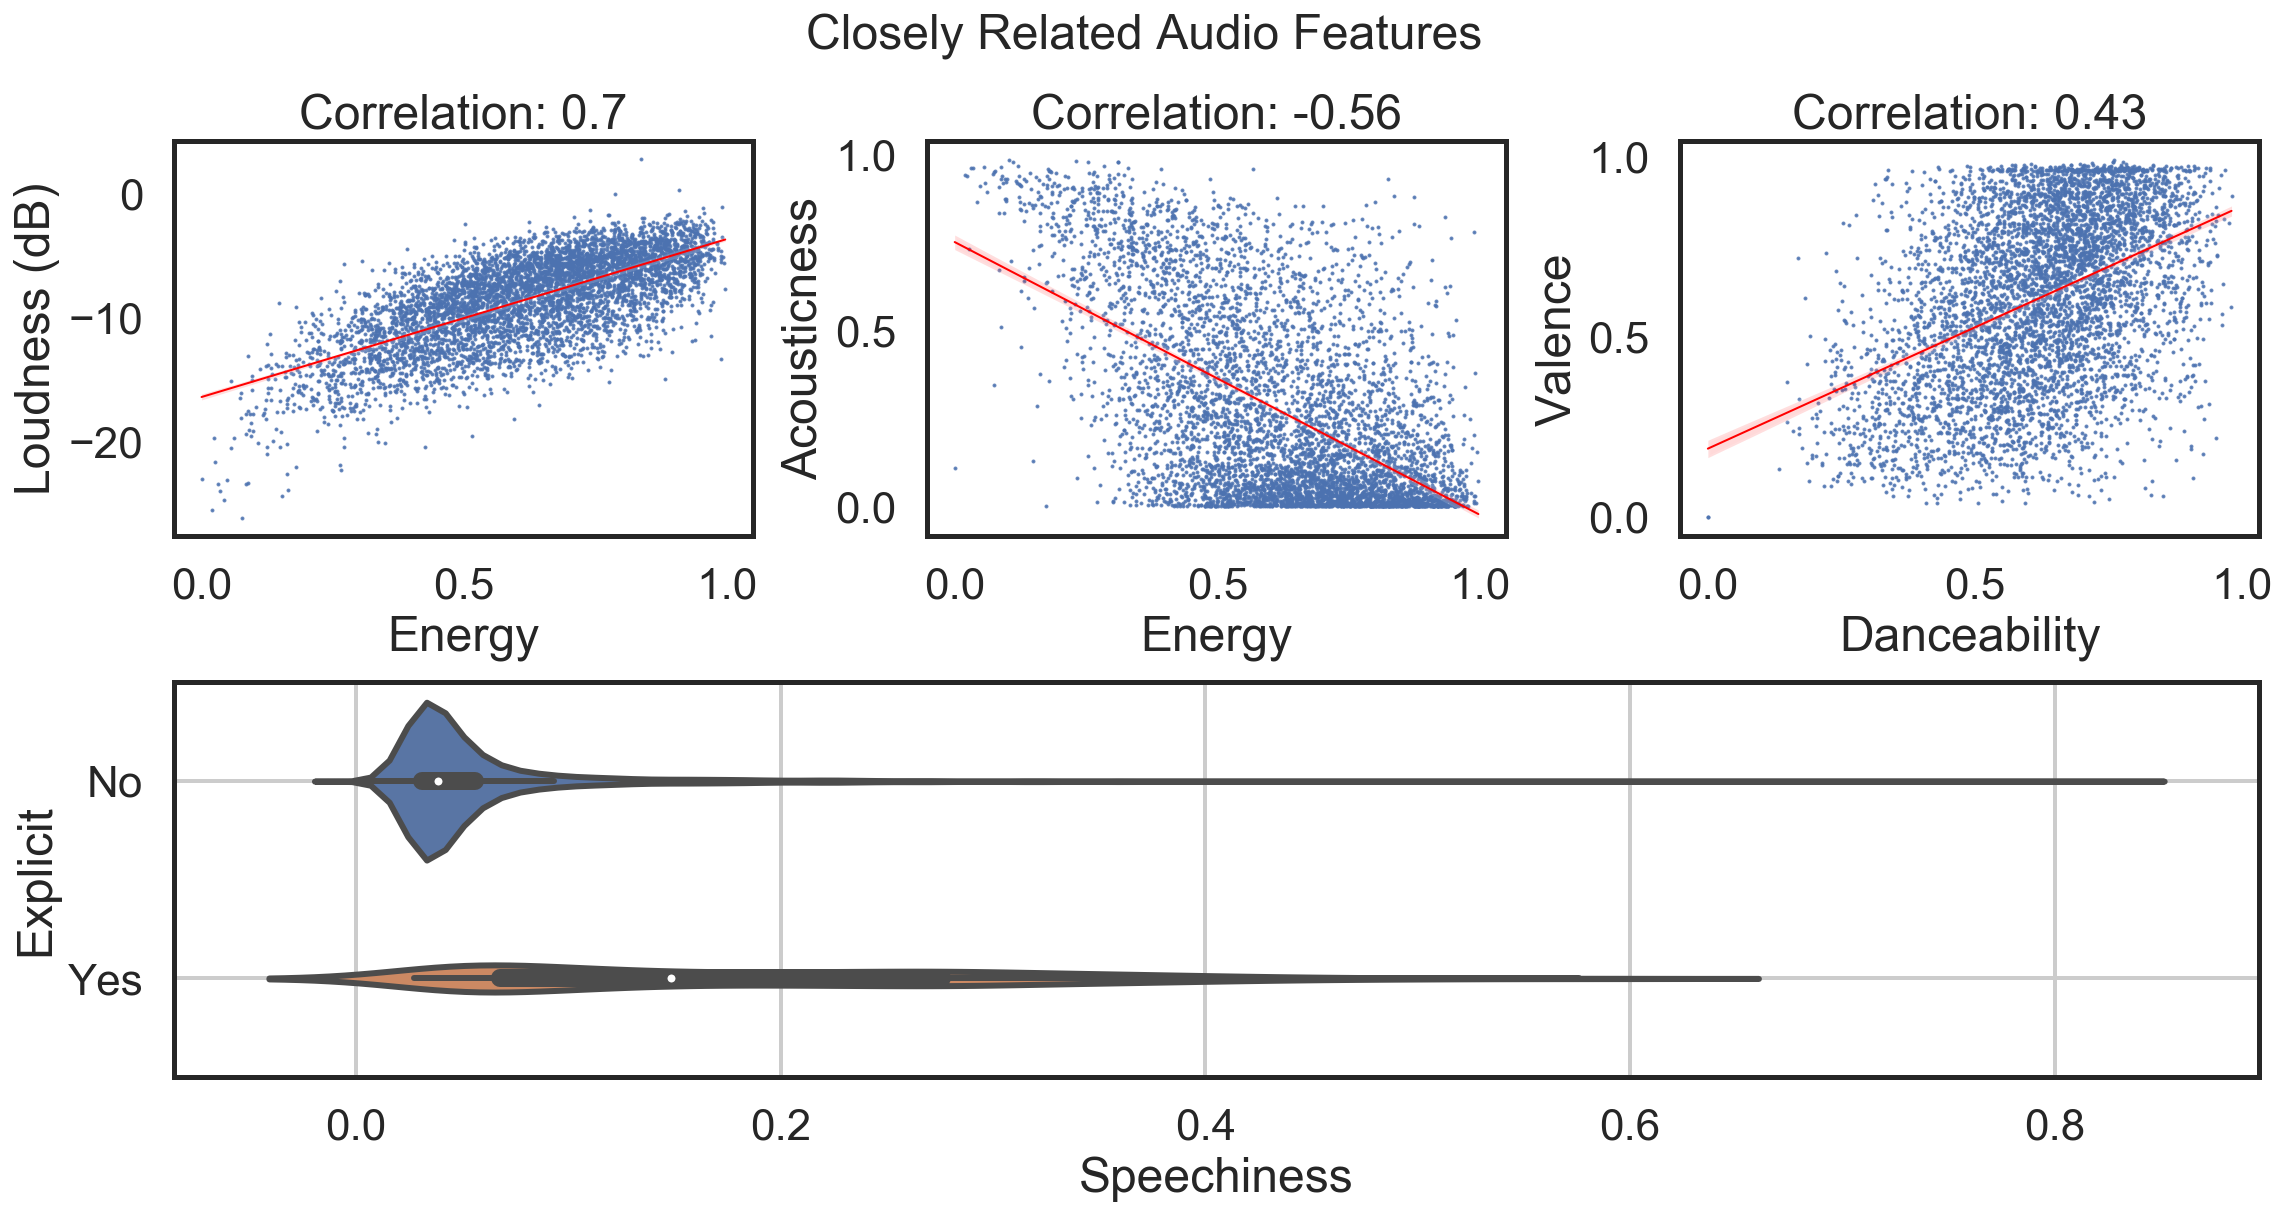

In [7]:
# generate subplot axes
axes = list()
plt.figure(figsize = (16,8))
grid_positions = [231, 232, 233, 212]
for position in grid_positions:
    axes.append(plt.subplot(position))
    
feature_pairs = [('energy', 'loudness'), ('energy', 'acousticness'),
                 ('danceability', 'valence')]

# generate upper scatter plots
for (x, y), ax in zip(feature_pairs, axes[:3]):
    r = np.corrcoef(df[x].dropna(), df[y].dropna())[0][1]
    sns.regplot(data=df, x=x, y=y, line_kws= {'linewidth': 1, 'color': 'red'},
                scatter_kws={'s': 1}, label='test', ax=ax)
    ax.set(title='Correlation: {:.2}'.format(r))
axes[0].set(ylabel='Loudness (dB)', xlabel='Energy')
axes[1].set(ylabel='Acousticness', xlabel='Energy')
axes[2].set(ylabel='Valence', xlabel='Danceability')


# generate lower violin plot
sns.violinplot(data=df, x='speechiness', y='explicit', orient='horizontal',
               split=True, ax=axes[3])
axes[3].grid(True)
axes[3].set(ylabel='Explicit', xlabel='Speechiness')
axes[3].set_yticks([0,1])
axes[3].set_yticklabels(['No', 'Yes'])

plt.tight_layout()
plt.suptitle('Closely Related Audio Features', fontsize=24, y=1.05)
plt.savefig('bivariate-distributions.png')